In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import keras.utils.to_categorical
#import keras_utils
from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
(X_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [4]:
label_dict = {
 0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck',
}

Text(0.5,1,'Label: frog')
Text(0.5,1,'Label: airplane')
Text(0.5,1,'Label: bird')
Text(0.5,1,'Label: automobile')
Text(0.5,1,'Label: bird')
Text(0.5,1,'Label: bird')


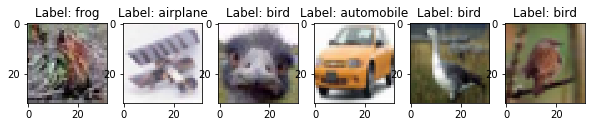

In [5]:
plt.figure(figsize=[10,5])
#subplot(nrows, ncols, index, **kwargs)
# Display the first image in training data
for i in range(6):
    plt.subplot(1,6,i+1)
    curr_img = np.reshape(X_train[i], (32,32,3))
    plt.imshow(curr_img)
    print(plt.title("Label: " + str(label_dict[y_train[i][0]])))



In [6]:
X_train = X_train.reshape((50000,-1))

In [7]:
"""
Preprocess data?
Normalize:
dataset=dataset/255.

Zero-centering:
mean = dataset.mean(axis=(0,1,2))
#keepdims=True
dataset[..., 0] -= mean[0]
dataset[..., 1] -= mean[1]
dataset[..., 2] -= mean[2]

Set std to 1:
std = dataset.std(axis=(0,1,2))
dataset[..., 0] /= std[0]
dataset[..., 1] /= std[1]
dataset[..., 2] /= std[2]
"""


'\nPreprocess data?\nNormalize:\ndataset=dataset/255.\n\nZero-centering:\nmean = dataset.mean(axis=(0,1,2))\n#keepdims=True\ndataset[..., 0] -= mean[0]\ndataset[..., 1] -= mean[1]\ndataset[..., 2] -= mean[2]\n\nSet std to 1:\nstd = dataset.std(axis=(0,1,2))\ndataset[..., 0] /= std[0]\ndataset[..., 1] /= std[1]\ndataset[..., 2] /= std[2]\n'

In [8]:
batchsize = 2048
X_train_batch = X_train[:batchsize, :]
y_train_batch = y_train[:batchsize]

In [9]:
from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
X_train_batch = preprocessing.normalize(X_train_batch)
#X_train_batch = scaler.fit_transform(X_train_batch) #does not work for ltsa

In [10]:
#y_train_batch = np.squeeze(y_train_batch).shape
y_train_batch = y_train_batch.reshape((batchsize,))

In [11]:
# simple example from manifold_intro
from megaman.embedding import LTSA
from megaman.geometry import Geometry

geom = Geometry(adjacency_kwds=dict(n_neighbors=64))
model = LTSA(geom=geom, eigen_solver='dense', random_state=64)

X_ltsa = model.fit_transform(X_train_batch)
print(X_ltsa.shape)

/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


(2048, 2)


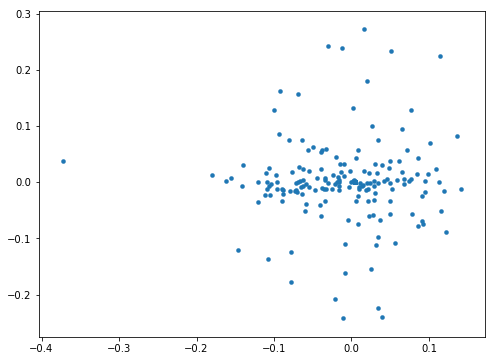

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_ltsa[:, 1], X_ltsa[:, 0], s=20, lw=0.1)

In [27]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [ ]:
plot_embedding(X_ltsa, y_train_batch)

In [13]:
# Initialize Radius
from megaman.geometry import Geometry
geom = Geometry()
geom.set_data_matrix(X_train_batch)

In [17]:
# Radius Selection
from scipy.sparse.csgraph import connected_components
rad1 = 0.1
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':rad1}
affinity_matrix = geom.compute_affinity_matrix({'radius':rad1})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components)

2048


In [19]:
radius = rad1
adjacency_method = 'cyflann'
adjacency_kwds = {'radius':radius}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}
laplacian_method = 'symmetricnormalized'
laplacian_kwds = {'scaling_epps':radius}

geom  = {'adjacency_method':adjacency_method, 'adjacency_kwds':adjacency_kwds,
         'affinity_method':affinity_method, 'affinity_kwds':affinity_kwds,
         'laplacian_method':laplacian_method, 'laplacian_kwds':laplacian_kwds}

In [20]:
geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)
geom.set_data_matrix(X_train_batch)

In [21]:
from megaman.embedding import (Isomap, LocallyLinearEmbedding,
                               LTSA, SpectralEmbedding)

In [22]:
n_components = 2

In [23]:
spectral = SpectralEmbedding(n_components=3, eigen_solver='amg',geom=geom, drop_first=False) # use 3 for spectral
embed_spectral = spectral.fit_transform(X_train_batch)

ltsa = LTSA(n_components=n_components,eigen_solver='dense',geom=geom)
embed_ltsa = ltsa.fit_transform(X_train_batch)

lle = LocallyLinearEmbedding(n_components=n_components, eigen_solver='dense',geom=geom)
embed_lle = lle.fit_transform(X_train_batch)

isomap = Isomap(n_components=n_components, eigen_solver='dense',geom=geom)
embed_isomap = isomap.fit_transform(X_train_batch)

/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
/home/ubuntujan/anaconda3/envs/manifold_env1/lib/python3.5/site-packages/sklearn/utils/validation.py:393: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", Deprecati

In [24]:
embed_spectral = embed_spectral[:, [0, 2]] * 50.0
tmp = embed_spectral[:, 1].copy()
embed_spectral[:,1] = embed_spectral[:,0].copy()
embed_spectral[:,0] = tmp.copy()
tmp = None

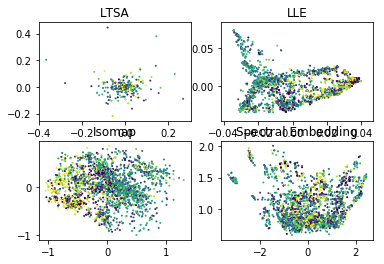

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0, 0].scatter(embed_ltsa[:, 0], embed_ltsa[:, 1], s=1, c=y_train_batch)
axes[0, 0].set_title('LTSA')
axes[0, 1].scatter(embed_lle[:, 0], embed_lle[:, 1], s=1, c=y_train_batch)
axes[0, 1].set_title('LLE')
axes[1, 0].scatter(embed_isomap[:, 0], embed_isomap[:, 1], s=1, c=y_train_batch)
axes[1, 0].set_title('Isomap')
axes[1, 1].scatter(embed_spectral[:, 0], embed_spectral[:, 1], s=1, c=y_train_batch)
axes[1, 1].set_title('Spectral Embedding')
plt.show()

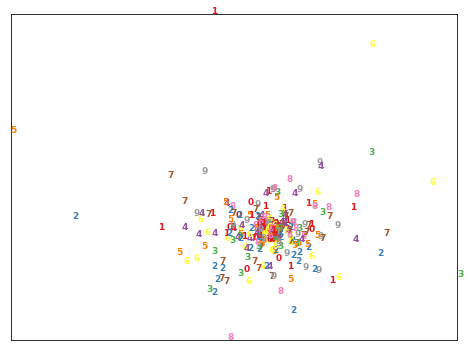

In [28]:
plot_embedding(embed_ltsa, y_train_batch)

In [ ]:
plot_embedding(embed_lle, y_train_batch)

In [ ]:
plot_embedding(embed_isomap, y_train_batch)

In [ ]:
plot_embedding(embed_spectral, y_train_batch)